In [1]:
# Daniel Bandala @ apr 2022
import cv2
import os.path
import requests
import numpy as np
import matplotlib.pyplot as plt

# YOLO (You Only Look Once)
YOLO is a new approach to object detection. Prior work on object detection repurposes classifiers to perform detection. Instead, it frames object detection as a regression problem to spatially separated bounding boxes and associated class probabilities. A single neural network predicts bounding boxes and class probabilities directly from full images in one evaluation. Since the whole detection pipeline is a single network, it can be optimized end-to-end directly on detection performance. This unified architecture is extremely fast. The base YOLO model processes images in real-time at 45 frames per second. A smaller version of the network, Fast YOLO, processes an astounding 155 frames per second while still achieving double the mAP of other real-time detectors. Compared to state-of-the-art detection systems, YOLO makes more localization errors but is far less likely to predict false detections where nothing exists. Finally, YOLO learns very general representations of objects. It outperforms all other detection methods, including DPM and R-CNN, by a wide margin when generalizing from natural images to artwork on both the Picasso Dataset and the People-Art Dataset (https://arxiv.org/abs/1506.02640).

In [2]:
# Download YOLO net config file
yolo_config = 'yolov3.cfg'
if not os.path.isfile(yolo_config):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
    r = requests.get(url)
    with open(yolo_config, 'wb') as f:
        f.write(r.content)

In [3]:
# Download YOLO net weights
yolo_weights = 'yolov3.weights'
if not os.path.isfile(yolo_weights):
    url = 'https://pjreddie.com/media/files/yolov3.weights'
    r = requests.get(url)
    with open(yolo_weights, 'wb') as f:
        f.write(r.content)

In [4]:
# Download class names file
# Contains the names of the classes the network can detect
classes_file = 'coco.names'
if not os.path.isfile(classes_file):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
    r = requests.get(url)
    with open(classes_file, 'wb') as f:
        f.write(r.content)

### The neural network estimate both the class and the class localitation
![YOLO Output](https://miro.medium.com/max/1400/0*BgV5JvtaOyg1UYjX.jpg)

In [5]:
# load class names
with open(classes_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

In [6]:
# load the network
net = cv2.dnn.readNet(yolo_weights, yolo_config)

In [7]:
image_file = 'streetview-oncomingtruck.jpg'
# read and normalize image
try:
    image = cv2.imread(image_file)
    blob = cv2.dnn.blobFromImage(image, 1 / 255, (416, 416), (0, 0, 0), True, crop=False)
except Exception as e:
    print(str(e))

In [8]:
# set as input to the net
net.setInput(blob)

In [9]:
# get network output layers
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

### Select the average maximum probability bounding box
![Bounding box probability map](https://miro.medium.com/max/1400/1*e0VY6U1_WMF2KBoKQNZvkQ.png)

In [10]:
# inference
# the network outputs multiple lists of anchor boxes,
# one for each detected class
outs = net.forward(output_layers)

In [11]:
# extract bounding boxes
class_ids = list()
confidences = list()
boxes = list()

In [12]:
# iterate over all classes
for out in outs:
    # iterate over the anchor boxes for each class
    for detection in out:
        # bounding box
        center_x = int(detection[0] * image.shape[1])
        center_y = int(detection[1] * image.shape[0])
        w = int(detection[2] * image.shape[1])
        h = int(detection[3] * image.shape[0])
        x = center_x - w // 2
        y = center_y - h // 2
        boxes.append([x, y, w, h])

        # class
        class_id = np.argmax(detection[5:])
        class_ids.append(class_id)

        # confidence
        confidence = detection[4]
        confidences.append(float(confidence))

In [13]:
# non-max suppression
# Bajo score_threshold y bajo nms_threshold provocan detectar mas objetos en la imagen
# Prueba1- score_threshold=0.3 / nms_threshold=0.5
# Prueba2- score_threshold=0.1 / nms_threshold=0.1
ids = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.2, nms_threshold=0.2)
# draw the bounding boxes on the image
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [14]:
for i in ids:
    #i = i[0]
    x, y, w, h = boxes[i]
    class_id = class_ids[i]

    color = colors[class_id]

    cv2.rectangle(image, (round(x), round(y)), (round(x + w), round(y + h)), color, 2)

    label = "%s: %.2f" % (classes[class_id], confidences[i])
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

#cv2.imshow("Object detection", image)
#cv2.waitKey()

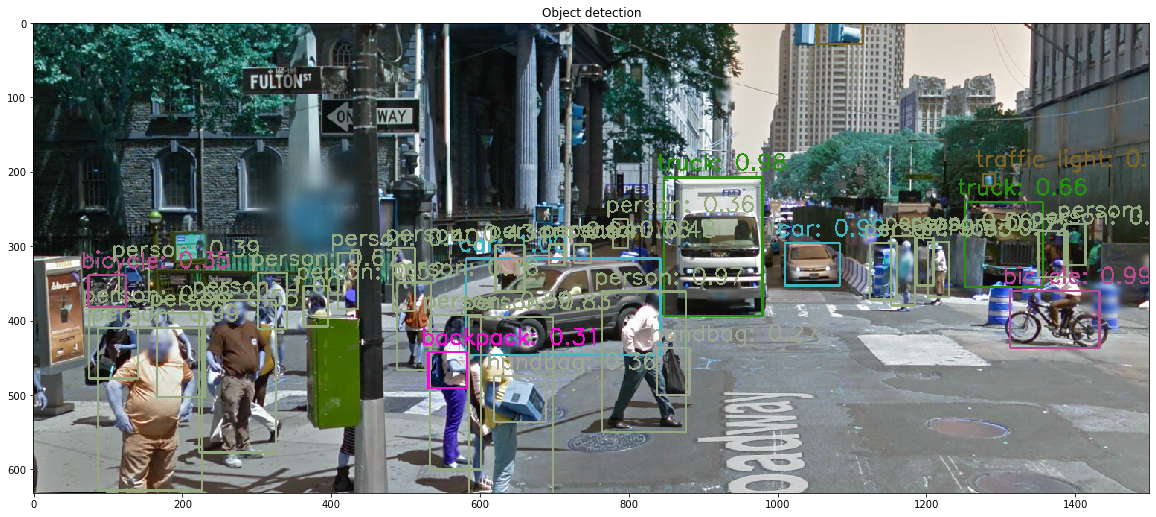

In [15]:
plt.figure(figsize=(20,12))
plt.imshow(image)
plt.title("Object detection")
plt.show()